In [1]:
import sys
import os
import json

sys.path.insert(19, 'litepose-pose-estimation/src')

from lp_coco_utils.lp_getDataset import getDatasetProcessed
from lp_training.lp_trainer import train
from lp_model.lp_litepose import LitePose
from lp_inference.lp_inference import inference, assocEmbedding
from lp_utils.lp_image_processing import drawHeatmap, drawKeypoints, drawSkeleton
from lp_testing.lp_evaluate import evaluateModel

import lp_config.lp_common_config as cc
import torch
import cv2

from thop import profile

from PIL import Image
import matplotlib.pyplot as plt
from urllib.request import urlopen

from torchvision import transforms

from IPython.display import display

import numpy as np
import pandas as pd
import av
import streamlink

from pytube import YouTube

from tqdm.notebook import tqdm

import time
from datetime import datetime

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Leggo il file di configurazione
with open('config/config.json') as f:
    config_data = json.load(f)

# Ottengo i percorsi dei file
file_path_big_arch = config_data['path_big_arch']

file_path_video = config_data['path_video']

file_path_csv_keypoints = config_data['path_csv_keypoints']
file_path_csv_keypoints_video = config_data['path_csv_keypoints_video'] 
file_path_csv_keypoints_webcam = config_data['path_csv_keypoints_webcam']

In [3]:
# Carico il modello già addestrato

model = LitePose().to(cc.config["device"])
model.load_state_dict(torch.load(file_path_big_arch, map_location=cc.config["device"]))

<All keys matched successfully>

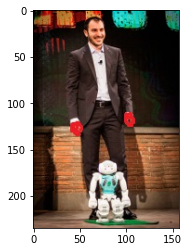

In [4]:
# Carico una immagine statica da url

url = 'https://web.unibas.it/bloisi/assets/images/bloisi_nao.jpg'
#url = 'https://previews.123rf.com/images/mimagephotography/mimagephotography1411/mimagephotography141100024/33214727-full-body-portrait-of-a-handsome-young-african-american-man-smiling-on-isolated-white-background.jpg'

#uri = "C:\\Users\\stolf\\Downloads\\Screenshot (113).png"
#uri = "C:\\Users\\stolf\\Downloads\\Screenshot (114).png"
#uri = "C:\\Users\\stolf\\Downloads\\Screenshot (115).png"
#uri = "C:\\Users\\stolf\\Downloads\\Screenshot (116).png"
#uri = "C:\\Users\\stolf\\Downloads\\Screenshot (117).png"
# uri = "C:\\Users\\stolf\\Downloads\\Screenshot (118).png"
uri = "C:\\Users\\stolf\\dev\\Progetto Visione e Percezione\\src\\referee_gloves_detector\\resources\\bloisi_nao_red_hands.png"

#img = Image.open(urlopen(url)).convert('RGB')
#frame = np.array(img)
#cv2.imshow("Array",frame)
#cv2.waitKey(90000)
#cv2.destroyAllWindows()
img = Image.open(uri).convert('RGB')
plt.grid(False)
_= plt.imshow(img)

In [5]:
# Adatto l'immagine alle dimensioni di un tensore PyTorch 

# Ridimensiono l'immagine
resize = transforms.Resize([224, 224])
img = resize(img)
to_tensor = transforms.ToTensor()

# Trasformo l'immagine in un tensore
tensor = to_tensor(img)
# torch.Size([3, 224, 224])

# Aggiungo un'altra dimensione per far corrispondere la shape del tensore alla shape (NCHW) di un tensore PyTorch
tensor = tensor.unsqueeze(0)
# torch.Size([1, 3, 224, 224])

In [6]:
# Inferisco i Keypoints dall'immagine

output, keypoints = inference(model, tensor)
embedding = assocEmbedding(keypoints)
#restricted_keypoints = [[keypoints[0][0], keypoints[0][1], keypoints[0][2], keypoints[0][3], keypoints[0][4], keypoints[0][5], keypoints[0][6],keypoints[0][7],keypoints[0][13]]]
restricted_keypoints = keypoints

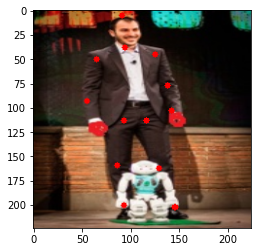

In [10]:
# Disegno i keypoints inferiti sull'immagine

idx = 0
img = drawKeypoints(tensor[idx], restricted_keypoints[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
plt.grid(False)
_= plt.imshow(im_pil)
im_pil.save('src.jpg')

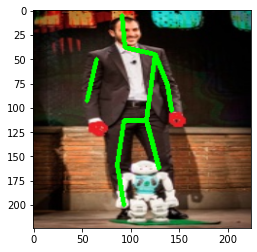

In [8]:
# Disegno lo skeleton a partire dai keypoints

idx = 0
img = drawSkeleton(tensor[idx], embedding[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
plt.grid(False)
_= plt.imshow(im_pil)

In [9]:
# Salvo solo i 9 keypoints scelti

#display(restricted_keypoints)
d = {'x': [], 'y': [], 'tag':[]}
df_keypoints = pd.DataFrame(data=d)
for i in range(len(restricted_keypoints[0])):
    if not (restricted_keypoints[0][i]):
        df_temp = pd.DataFrame([{'x':np.nan, 'y':np.nan, 'tag':np.nan}])
        df_keypoints = pd.concat([df_keypoints, df_temp])
    else:
        df_temp = pd.DataFrame(restricted_keypoints[0][i])
        df_keypoints = pd.concat([df_keypoints, df_temp])
df_keypoints.reset_index(drop=True, inplace=True)
df_keypoints.to_csv(file_path_csv_keypoints, index=False)
#df_keypoints.head(10)

In [ ]:
# Carico una video da url

def video_downloader(link):
    youtubeObject = YouTube(link)
    youtubeObject = youtubeObject.streams.get_by_resolution("360p")
    try:
        youtubeObject.download(filename='referee.mp4')
    except:
        raise Exception("Si è verificato un errore nel download del video")
    print("Download completato correttamente")


url = 'https://youtu.be/bBuDwm6JrZw'
video_downloader(url)

# Apro il file video
cap = cv2.VideoCapture(file_path_video)

# Verifico se il video è stato aperto correttamente
if not cap.isOpened():
    raise Exception("Errore nell'apertura del video")

frames = []
timestamps = []
ret, frame = cap.read()
count = 0
while ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    frames.append(im_pil)
    # Ottengo l'istante attuale
    istante_attuale = datetime.now()
    # Converto l'istante in una stringa nel formato desiderato
    stringa_istante = istante_attuale.strftime("%d/%m/%Y %H:%M:%S.%f")
    timestamps.append(stringa_istante)
    # Leggo il successivo frame
    ret, frame = cap.read()
    count += 1
    # Imposto il frame successivo da leggere dopo 15 ms
    cap.set(cv2.CAP_PROP_POS_MSEC, count * 15)

# Chiudo il file video
cap.release()

# Stampo le dimensioni dell'array
print("Dimensioni dell'array di frame:", len(frames))
print("Dimensioni dell'array di timestamp:", len(timestamps))

In [ ]:
# Diminuisco il numero di frame per alleggerire il carico computazionale

frames = frames[0:500]
timestamps = timestamps[0:500]

In [ ]:
# Adatto le immagini alle dimensioni dei tensori PyTorch 

display(len(frames)) # numero di frames (immagini)

# Adatto i frames alle dimensioni di un tensore PyTorch 
resize = transforms.Resize([224, 224])  
to_tensor = transforms.ToTensor() 
tensors = [] # Creo la lista di tensori
for frame in frames:
    frame = resize(frame) # Ridimensiono le dimensioni dei frames
    tensor = to_tensor(frame) # Trasformo il frame in tensore
    tensor = tensor.unsqueeze(0) # Aggiungo un'altra dimensione per far corrispondere la shape del tensore alla shape (NCHW) di un tensore PyTorch
    tensors.append(tensor) # Aggiungo il frame convertito in tensore alla lista di tensori

display(len(tensors))

In [ ]:
# Inferisco i Keypoints dai frame

restricted_keypoints_vec = []
embedding_vec = []
for tensor in tqdm(tensors):
    output, keypoints = inference(model, tensor)
    embedding = assocEmbedding(keypoints)
    restricted_keypoints = [[keypoints[0][0], keypoints[0][1], keypoints[0][2], keypoints[0][3], keypoints[0][4], keypoints[0][5], keypoints[0][6],keypoints[0][7],keypoints[0][13]]]    
    restricted_keypoints_vec.append(restricted_keypoints)
    embedding_vec.append(embedding)

In [ ]:
# Disegno i keypoints inferiti sui frame

idx = 0
for tensor, restricted_keypoints in zip(tensors, restricted_keypoints_vec):
    frame = drawKeypoints(tensor[idx], restricted_keypoints[idx])
    cv2.imshow("Image Keypoints", frame)
    cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# Disegno gli skeleton a partire dai keypoints

idx = 0
for tensor, embedding in zip(tensors, embedding_vec):
    frame = drawSkeleton(tensor[idx], embedding[idx])
    cv2.imshow("Image Keypoints", frame)
    cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# Salvo solo i 9 keypoints scelti per ogni frame

d = {'timestamp':[],'x': [], 'y': [], 'tag':[]}
df_keypoints = pd.DataFrame(data=d)
for timestamp, restricted_keypoints in zip(timestamps, restricted_keypoints_vec):
    for i in range(len(restricted_keypoints[0])):
        if not (restricted_keypoints[0][i]):
            df_temp = pd.DataFrame([{'timestamp': '01/01/1970 01:00:00','x':np.nan, 'y':np.nan, 'tag':np.nan}])
            df_keypoints = pd.concat([df_keypoints, df_temp])
        else:
            df_temp = pd.DataFrame(restricted_keypoints[0][i])
            df_temp['timestamp'] = timestamp
            df_keypoints = pd.concat([df_keypoints, df_temp])
df_keypoints.to_csv(file_path_csv_keypoints_video, index=False)
df_multiindex = df_keypoints.set_index(['timestamp'])
#display(df_multiindex)

In [ ]:
# Apro la webcam e salvo al volo i frame e il timestamp

# Creo un oggetto di tipo webcam collegato alla webcam di default.
# 0 indica la webcam predefinita, se sono presenti più webcam è possibile specificare il numero corrispondente
webcam=cv2.VideoCapture(0) 

# Verifico se il video è stato aperto correttamente
if not webcam.isOpened():
    raise Exception("Errore nell'apertura della webcam")

frames = []
timestamps = []
resize = transforms.Resize([224, 224])  
to_tensor = transforms.ToTensor()
ret,frame=webcam.read()
while ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = img[:,80:]
    img = img[:,:-80]
    im_pil = Image.fromarray(img)
    frames.append(im_pil)
    # Ottengo l'istante attuale
    istante_attuale = datetime.now()
    # Converto l'istante in una stringa nel formato desiderato
    stringa_istante = istante_attuale.strftime("%d/%m/%Y %H:%M:%S.%f")
    timestamps.append(stringa_istante) 
    # Catturo l'input da tastiera,la funzione cv2.waitKey() attende per un determinato numero di millisecondi 
    # (nel caso specifico 15) e restituisce un valore intero che rappresenta il tasto premuto dall'utente.
    # Il risultato viene assegnato alla variabile key. L'operatore & viene utilizzato per fare una maschera bit a bit 
    # con il valore esadecimale 0xFF, che rappresenta 255 in decimale. Ciò serve per estrarre solo gli ultimi 8 bit 
    # del valore restituito, ignorando eventuali bit aggiuntivi.
    # Con if key==ord("q") verifico se il tasto premuto dall'utente corrisponde alla lettera "q"(quit).
    # La funzione ord() restituisce il valore intero che rappresenta il carattere passato come argomento, 
    # quindi ord("q") restituisce il valore intero corrispondente alla lettera "q" (che di solito è 113 in decimale). 
    frame = resize(im_pil)
    tensor = to_tensor(frame)
    tensor = tensor.unsqueeze(0)
    if ret==True:
        output, keypoints = inference(model, tensor)
        embedding = assocEmbedding(keypoints)
        frame = drawSkeleton(tensor[0], embedding[0])
        #frame = drawKeypoints(tensor[0], keypoints[0])
        cv2.imshow("Image Keypoints", frame)
        key=cv2.waitKey(1) & 0xFF
        if key==ord("q"):
            break         
    # Leggo il successivo frame
    ret, frame = webcam.read()

# Chiudo la webcam
webcam.release()
cv2.destroyAllWindows()
# Stampo le dimensioni dell'array
print("Dimensioni dell'array di frame:", len(frames))
print("Dimensioni dell'array di timestamp:", len(timestamps))

In [ ]:
# Adatto le immagini alle dimensioni dei tensori PyTorch 

display(len(frames)) # numero di frames (immagini)

# Adatto i frames alle dimensioni di un tensore PyTorch 
resize = transforms.Resize([224, 224])  
to_tensor = transforms.ToTensor() 
tensors = [] # Creo la lista di tensori
for frame in frames:
    frame = resize(frame) # Ridimensiono le dimensioni dei frames
    tensor = to_tensor(frame) # Trasformo il frame in tensore
    tensor = tensor.unsqueeze(0) # Aggiungo un'altra dimensione per far corrispondere la shape del tensore alla shape (NCHW) di un tensore PyTorch
    tensors.append(tensor) # Aggiungo il frame convertito in tensore alla lista di tensori

display(len(tensors))

In [ ]:
# Inferisco i Keypoints dai frame

restricted_keypoints_vec = []
embedding_vec = []
for tensor in tqdm(tensors):
    output, keypoints = inference(model, tensor)
    embedding = assocEmbedding(keypoints)
    restricted_keypoints = [[keypoints[0][0], keypoints[0][1], keypoints[0][2], keypoints[0][3], keypoints[0][4], keypoints[0][5], keypoints[0][6],keypoints[0][7],keypoints[0][13]]]    
    restricted_keypoints_vec.append(restricted_keypoints)
    embedding_vec.append(embedding)

In [ ]:
# Disegno i keypoints inferiti sui frame

idx = 0
for tensor, restricted_keypoints in zip(tensors, restricted_keypoints_vec):
    frame = drawKeypoints(tensor[idx], restricted_keypoints[idx])
    cv2.imshow("Image Keypoints", frame)
    cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# Disegno gli skeleton a partire dai keypoints

idx = 0
for tensor, embedding in zip(tensors, embedding_vec):
    frame = drawSkeleton(tensor[idx], embedding[idx])
    cv2.imshow("Image Keypoints", frame)
    cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# Salvo solo i 9 keypoints scelti per ogni frame

d = {'timestamp':[],'x': [], 'y': [], 'tag':[]}
df_keypoints = pd.DataFrame(data=d)
for timestamp, restricted_keypoints in zip(timestamps, restricted_keypoints_vec):
    for i in range(len(restricted_keypoints[0])):
        if not (restricted_keypoints[0][i]):
            df_temp = pd.DataFrame([{'timestamp': '01/01/1970 01:00:00','x':np.nan, 'y':np.nan, 'tag':np.nan}])
            df_keypoints = pd.concat([df_keypoints, df_temp])
        else:
            df_temp = pd.DataFrame(restricted_keypoints[0][i])
            df_temp['timestamp'] = timestamp
            df_keypoints = pd.concat([df_keypoints, df_temp])
df_keypoints.to_csv(file_path_csv_keypoints_webcam, index=False)
df_multiindex = df_keypoints.set_index(['timestamp'])
display(df_multiindex)